# Determining $\Sigma_{10}$, $\Sigma_{10}$ flux selected, $\Sigma_{20}$, $\Sigma_{20}$ flux selected of DESIJ1018-0121

**Author(s)**: Muhammad Jobair Hasan, Anowar Shajib

**Acknowledgement(s)**: S M Rafee Adnan, Ahmad Al-Imtiaz

## Import libraries and load data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [4]:
data, header = fits.getdata(
    "/content/drive/MyDrive/DESIJ1018-0121_F140W_drz_sci.fits", header=True
)

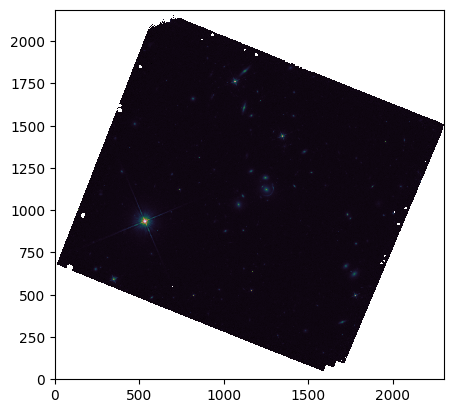

In [5]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [6]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

<ipython-input-7-eab7ae52f2d2>:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


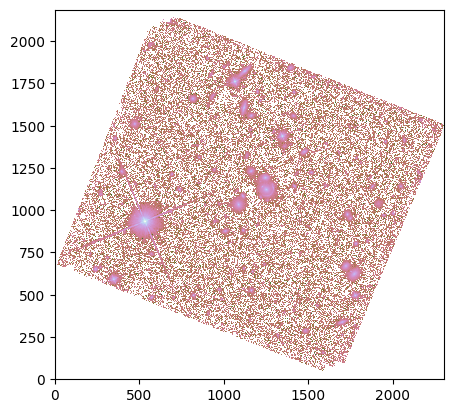

In [7]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [8]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.556446606064535, 0.018621376261014275)

In [9]:
bkg_subtracted_data = data - bkg.background

In [10]:
threshold = 4 * bkg.background_rms

In [11]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [12]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [13]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2187, 2305)
nlabels: 585
labels: [  1   2   3   4   5 ... 581 582 583 584 585]


In [14]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 585
labels: [  1   2   3   4   5 ... 581 582 583 584 585]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region surrounding your lensing system

In [15]:
set_x_lim1, set_x_lim2 = 1257 - 500, 1257 + 500
set_y_lim1, set_y_lim2 = 1127 - 500, 1127 + 500

<ipython-input-16-32e00dde14ba>:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


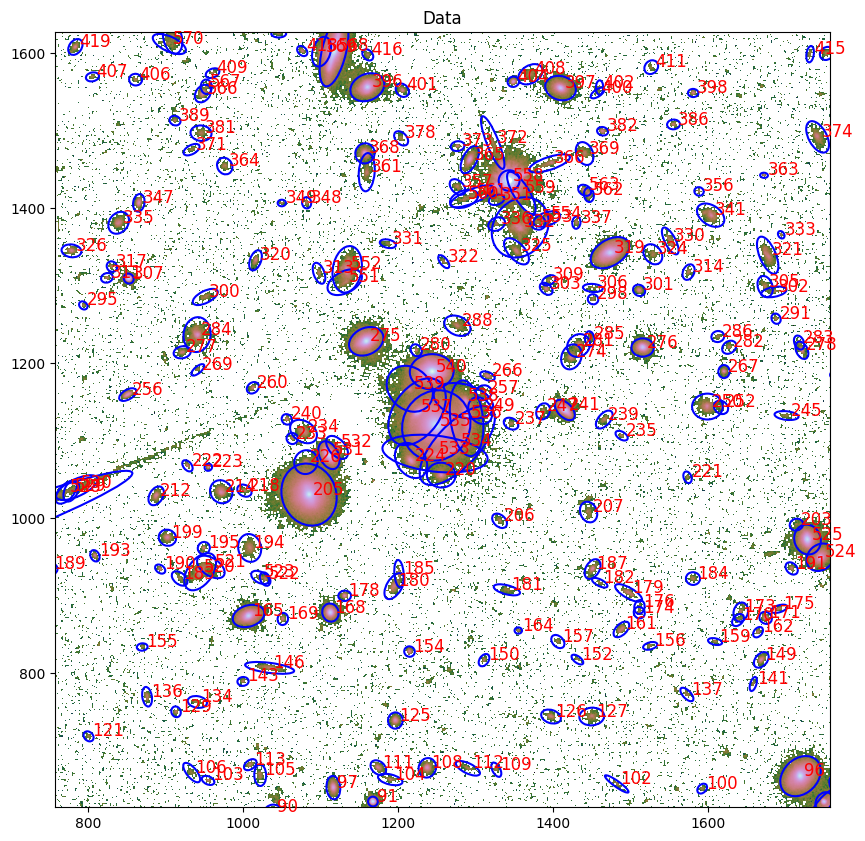

In [16]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in range(len(cat)):
  if np.abs(cat.xcentroid[i] - cat.xcentroid[535]) < 500 and np.abs(cat.ycentroid[i] - cat.ycentroid[535]) < 500:
    ax1.text(
        cat.xcentroid[i] + 5,
        cat.ycentroid[i],
        f"{i}",
        c="r",
        fontsize=12
        # transform=ax1.transAxes
    )

# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## The central deflector

<ipython-input-17-9cb5a5995fde>:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


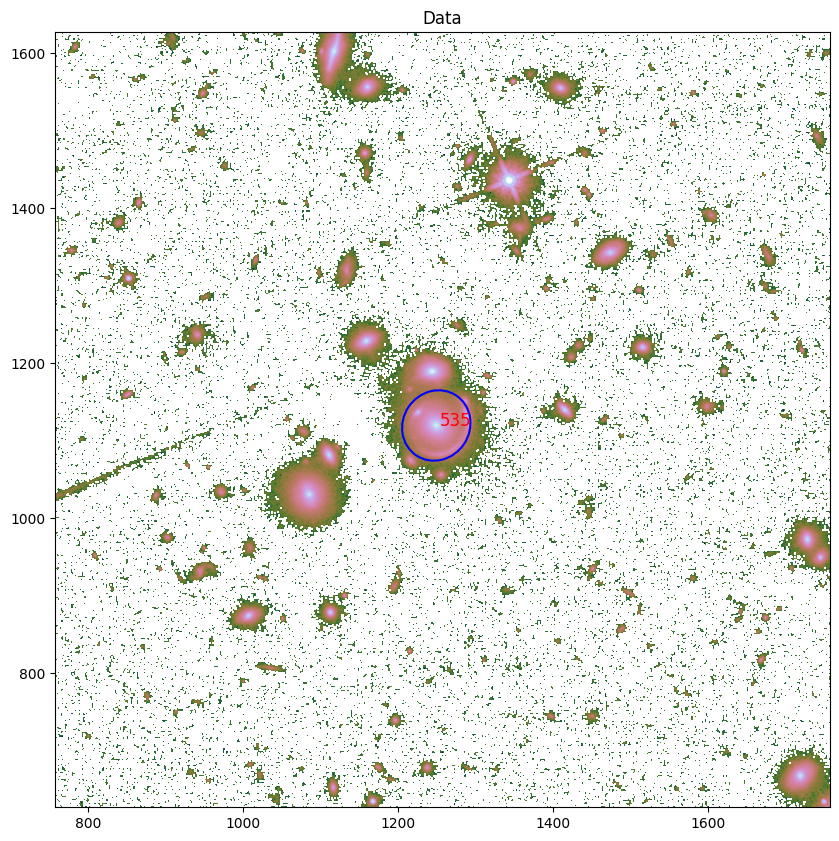

In [17]:
# object id of your central deflector/lens
id_central = 535

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12
    # transform=ax1.transAxes
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [18]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating Lists of neighbouring Galaxies

In [19]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (
        np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08
    ):  # radius: 30 arcseconds
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]['eccentricity'].value**2))
print("Number of All Close galaxies within 30 arcseconds radius:", len(close_galaxies_all))

Number of All Close galaxies within 30 arcseconds radius: 107


In [20]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08) & (
        f > f0 * 0.01
    ):  # radius: 30 arcseconds
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]['eccentricity'].value**2))
print("Number of Close galaxies (excluding the dim sources) within 30 arcseconds radius: ", len(close_galaxies_1))

Number of Close galaxies (excluding the dim sources) within 30 arcseconds radius:  29


In [21]:
def distance_arcsec(pixel_distance):
  """
  Convert distance from unit of pixels into arcsec unit.

  :param pixel_distance: distance in unit of pixels

  :return: distance in arcsec unit
  """
  wcs = WCS(header)

  # Get the pixel scale in degrees per pixel
  pix_scale_deg = abs(wcs.wcs.cd[0, 0])

  # Convert pixel scale to arcseconds
  pix_scale_arcsec = pix_scale_deg * 3600

  dist_arcsec = pixel_distance * pix_scale_arcsec

  return dist_arcsec

In [22]:
id_central_2drop = [533, 534, 535, 536, 537] # parts of the central deflector
id_others_2drop = [558, 559, 560, 561, 366, 372, 351] # stars with diffraction spikes

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# drop the central and other unwanted ids
df_all = df_all.drop(index=id_central_2drop)
df_all = df_all.drop(index=id_others_2drop)

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")
df_all_sys_removed = df_all_sorted

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)         Flux  Axis Ratio
538         47.306908          3.784553   180.449670    0.538863
224         55.646479          4.451718   105.301864    0.731890
539         58.433951          4.674716   132.831034    0.818705
249         59.858272          4.788662    31.656733    0.775718
220         64.351086          5.148087    63.262906    0.866381
540         69.640105          5.571208  2056.446245    0.800757
257         73.973544          5.917884    13.503932    0.874844
266         91.852075          7.348166    11.332009    0.525778
237         96.487813          7.719025     5.031179    0.705365
280        100.443682          8.035495     6.966922    0.808537
532        131.146637         10.491731    21.234413    0.585015
288        131.582996         10.526640    18.174187    0.679992
247        139.031841         11.122547     6.522640    0.781579
275        141.307419         11.304594   834.316567    0.733011
531        143.694314    

In [23]:
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system and other undesirable members
df_1_sys_removed = df_1_sorted.drop(index=id_central_2drop + [558, 559]) # 558 and 559 are the non-central star ids (excluding the dim sources)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)         Flux  Axis Ratio
538         47.306908          3.784553   180.449670    0.538863
224         55.646479          4.451718   105.301864    0.731890
539         58.433951          4.674716   132.831034    0.818705
220         64.351086          5.148087    63.262906    0.866381
540         69.640105          5.571208  2056.446245    0.800757
275        141.307419         11.304594   834.316567    0.733011
531        143.694314         11.495545   520.666509    0.630336
241        167.009759         13.360781   366.515373    0.567819
226        174.691935         13.975355    35.946089    0.936974
205        186.835582         14.946847  1829.509505    0.856775
552        231.971437         18.557715   112.898780    0.612422
168        277.370334         22.189627   209.431692    0.884520
332        277.600470         22.208038   156.317940    0.827663
276        284.650592         22.772047   209.137062    0.815129
214        290.375387    

## Determining $\Sigma_{10}$, $\Sigma_{10}$ flux selected, $\Sigma_{20}$, $\Sigma_{20}$ flux selected and the corresponding $R_{10}$s

<ipython-input-24-f44348d9d214>:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-24-f44348d9d214>:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-24-f44348d9d214>:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-24-f44348d9d214>:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: 14.946846550784985
R 20: 28.060018022337545
Sigma 10: 0.014247903841723222
Sigma 20: 0.008085450668456805

FOR All SOURCES
R 10: 8.03549459616533
R 20: 14.934625257757569
Sigma 10: 0.04929750055606735
Sigma 20: 0.02854246410794938


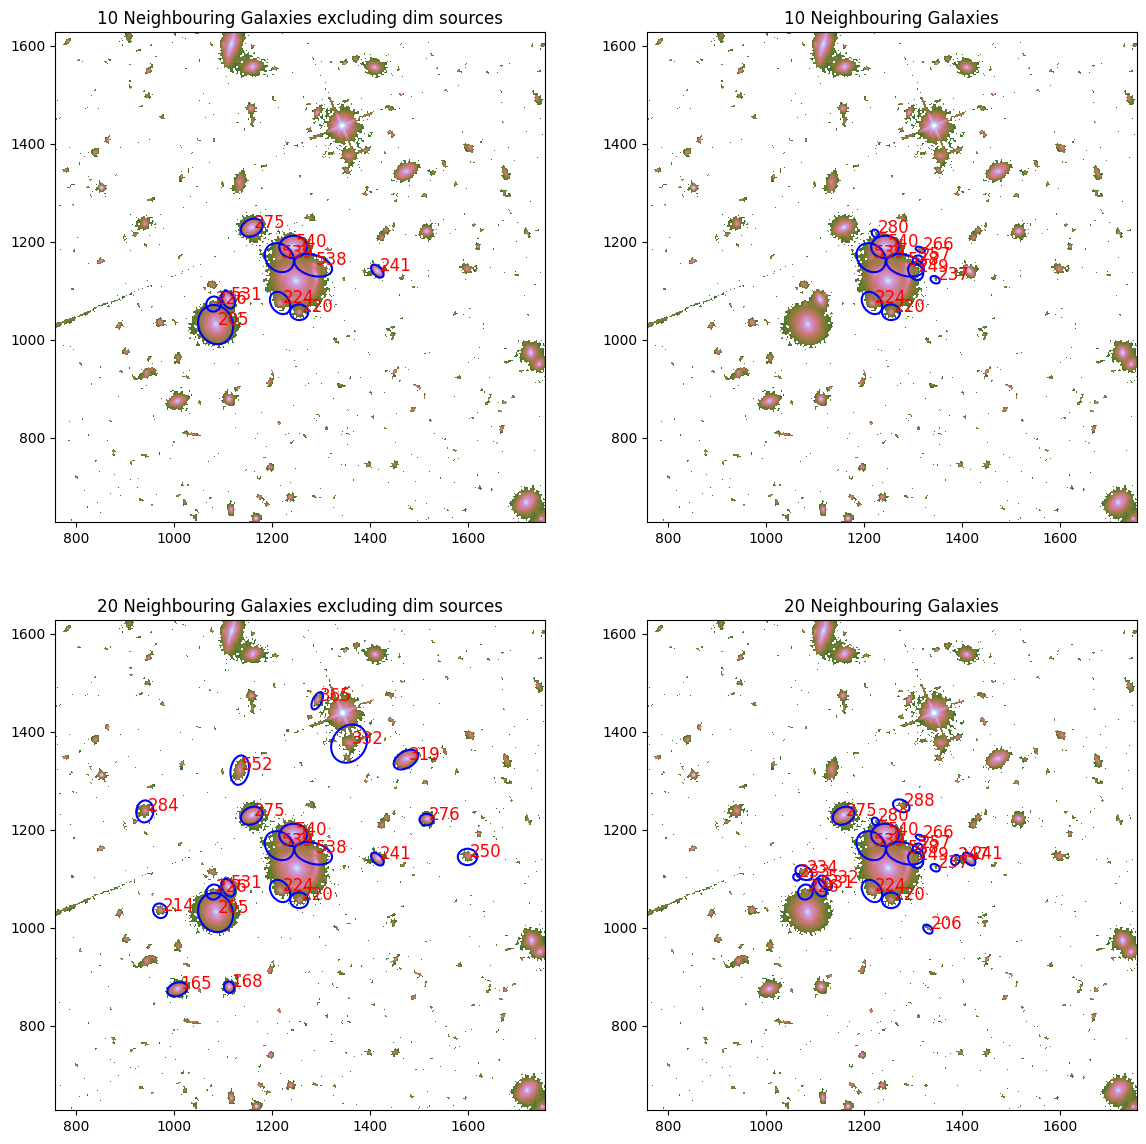

In [24]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(arcsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(arcsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

## Store the $\Sigma_{10}$, $\Sigma_{10}$ flux selected, $\Sigma_{20}$, $\Sigma_{20}$ flux selected values in the YAML file

In [25]:
# convert the numpy.float64 values to floats

Sigma_10_all = Sigma_10_all.item()
Sigma_10_1 = Sigma_10_1.item()
Sigma_20_all = Sigma_20_all.item()
Sigma_20_1 = Sigma_20_1.item()

In [26]:
# Existing YAML file with other parameters
existing_yaml_file = "/content/drive/MyDrive/DESIJ1018-0121_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10": Sigma_10_all,
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20": Sigma_20_all,
    "Sigma_20_flux_selected": Sigma_20_1,
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [27]:
# Read the YAML file using safe_load

with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 1.2292172377993058, 'Sigma_10': 0.04929750055606735, 'Sigma_10_flux_selected': 0.014247903841723222, 'Sigma_20': 0.02854246410794938, 'Sigma_20_flux_selected': 0.008085450668456805, 'center_x_light': [0.1023948913768942, 0.0004097599327291951, 0.0004485985085248695], 'center_x_mass': [0.19385946821368283, 0.002571438856372732, 0.0029750119284057686], 'center_y_light': [-0.07768142883406795, 0.0003824143511242384, 0.0002740520689160503], 'center_y_mass': [0.07822717272290364, 0.001417897443575386, 0.0019630081951761275], 'gamma': [1.4875622865735942, 0.013449065761565349, 0.012884708550801705], 'gamma_shear': [0.07918012860159501, 0.002164405937236061, 0.0022868703212080566], 'phi_light': [0.6504342042111888, 0.00386057316278976, 0.004236418364143457], 'phi_mass': [0.7940166933711206, 0.00599676610746791, 0.004996247353637351], 'phi_shear': [0.7970644924190506, 0.009939769411163257, 0.008850769464660901], 'q_light': [0.8145204146661666, 0.